In [1]:
import os
import pandas as pd
import pickle, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dl_portfolio.ae_data import load_data
from dl_portfolio.utils import load_result, load_result_wrapper
import sys
import itertools
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, spearmanr, kendalltau

%matplotlib inline

# Some useful functions

In [2]:
def plt_features(features,  start, end, dataset, savepath=None):
    if dataset == "dataset1":
        nrow, ncol = 2,2
        figsize=(12,10)
    elif dataset == "dataset2":
        nrow, ncol = 2,3
        figsize=(18,10)
        
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True, sharey=True)
    for i, c in enumerate(features["ae"].columns):
        temp = features["ae"].loc[start:end]
        if i % ncol == 0:
            if i > 0:
                row = 1
            else:
                row = 0
        col = i % ncol

        min_ = np.min(temp[c]) - 1
        max_ = np.max(temp[c]) + 1
        X_plot = np.linspace(min_, max_, 1000)[:, np.newaxis]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(np.random.normal(size=1000).reshape(-1,1))
        norm_log_dens = kde.score_samples(X_plot)

        axs[row, col].plot(X_plot[:, 0], np.exp(norm_log_dens), label='normal', color="green")

        kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(temp[c].values.reshape(-1,1))
        log_dens = kde.score_samples(X_plot)

        _ = axs[row, col].hist(temp[c], bins = 50, density=True, alpha=0.25, 
                               histtype='stepfilled',  edgecolor='none', color="blue")
        axs[row, col].plot(X_plot[:, 0], np.exp(log_dens), label='ae', color="blue")
        if savepath is None:
            axs[row, col].legend()
            axs[row, col].set_title(c)
        
        
        temp = features["nmf"].loc[start:end]
        
        min_ = np.min(temp[c]) - 1
        max_ = np.max(temp[c]) + 1
        X_plot = np.linspace(min_, max_, 1000)[:, np.newaxis]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(temp[c].values.reshape(-1,1))
        log_dens = kde.score_samples(X_plot)

        _ = axs[row, col].hist(temp[c], bins = 50, density=True, alpha=0.25,
                               histtype='stepfilled',  edgecolor='none', color="purple")
        axs[row, col].plot(X_plot[:, 0], np.exp(log_dens), label='nmf', color="purple")
        if savepath is None:
            axs[row, col].legend()
            axs[row, col].set_title(c)
        axs[row, col].set_xlim(-10,10)
        
    if dataset == "dataset2":
        axs[1,2].remove()

    plt.subplots_adjust(hspace = .1)
    plt.subplots_adjust(wspace = .1)

    if savepath:
        plt.savefig(savepath, bbox_inches='tight', transparent=True)

def plot_factor_corr(components, c1, c2, assets, t =0.05, components2 = None, show=False, unit_circle=False, 
                     title=None, savepath=None, ax = None):
    
    if ax is None:
        (fig, ax) = plt.subplots(figsize=(20, 20))
    ax.plot([-1,1], [0, 0], '--', c='black')
    ax.plot([0,0], [-1,1], '--', c='black')
    
    for i in range(0, len(assets)):
        if components[c1, i] > t or components[c2, i] > t:
            ax.arrow(0,
                     0,  # Start the arrow at the origin
                     components[c1, i],  #0 for PC1
                     components[c2, i],  #1 for PC2
                     # width = 0.01, # float, default: 0.001
                     head_width=0.025,
                     head_length=0.025, 
                     color='b')
            ax.text(components[c1, i] + 0.02,
                     components[c2, i] + 0.02,
                     assets[i],
                    size=15,
                    c='b')
            
    if components2 is not None:
        for i in range(0, len(assets)):
            if components2[c1, i] > t or components2[c2, i] > t:
                ax.arrow(0,
                         0,  # Start the arrow at the origin,
                         components2[c1, i],  #0 for PC1
                         components2[c2, i],  #1 for PC2
                         # width = 0.01, # float, default: 0.001
                         head_width=0.025,
                         head_length=0.025,
                         color='r')
                ax.text(components2[c1, i] + 0.02,
                        components2[c2, i] + 0.02,
                        assets[i],
                    size=15,
                        c='r')

    if unit_circle:
        an = np.linspace(0, 2 * np.pi, 100)
        ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
        ax.axis('equal')
    else:
        ax.xlim([-0.05, 1])
        ax.ylim([-0.05, 1])

    if title:
        ax.set_title(title)
    else:
        ax.set_title('Variable factor map')
    
    if ax is None:
        ax.set_xlabel(f'dim {c1}')
        ax.set_ylabel(f'dim {c2}')

    ax.set(adjustable='box', aspect='equal')
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', transparent=False)
    if show:
        plt.show()
        
def get_corr_factor_asset(test_data, features, corr="pearson"):
    if corr == "pearson":
        corr_measure = pearsonr
    elif corr == "spearman":
        corr_measure = spearmanr
    elif corr == "kendall":
        corr_measure = kendalltau
    else:
        raise NotImplementedError()
        
    corr_asset_factor = pd.DataFrame(index = test_data.columns, columns = features.columns)
    for c in features.columns:
        for a in test_data.columns:
            corr_asset_factor.loc[a, c], p_value = corr_measure(test_data[a], features[c])
            if p_value >= 0.05:
                corr_asset_factor.loc[a, c] = 0
    return corr_asset_factor

def intrepretation_plot(test_data, features, dataset, labels, corr="pearson", savepath=None):
    pairs = list(itertools.combinations(labels, 2))
    ind_pairs = list(itertools.combinations(list(range(len(labels))), 2))

    corr_ae = get_corr_factor_asset(test_data, features["ae"], corr=corr)
    corr_nmf = get_corr_factor_asset(test_data, features["nmf"], corr=corr)


    if dataset == "dataset1":
        figsize = (40,15)
        nrow=2
        ncol=3
    else:
        nrow=2
        ncol=5
        figsize = (20,10)
    fig, axs = plt.subplots(nrow, ncol, figsize = figsize, sharex=True, sharey=True)

    col = 0
    row = -1
    for i, dims in enumerate(ind_pairs):
        if i % ncol == 0:
            row +=1
        if i >= ncol:
            col = i - ncol
        else:
            col = i
        dim1=dims[0]
        dim2=dims[1]
        name1=pairs[i][0]
        name2=pairs[i][1]
        plot_factor_corr(corr_ae.values.T, dim1, dim2, assets, t=0, components2=corr_nmf.T.values, 
                         title = f"{name2} vs {name1}",
                         unit_circle=True, savepath=None, ax = axs[row,col])
    fig.subplots_adjust(hspace=0, wspace=0.05)
    
    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight', transparent=True)

# Input: set datatset name ("dataset1" or "dataset2")

In [3]:
DATASET = 'dataset2'

# Save directory

In [4]:
SAVE = True
savedir = "paper_result"
if SAVE:
    if not os.path.isdir(savedir):
        os.mkdir(savedir)


# Load results

In [5]:
test_set = 'test'
if DATASET == 'dataset1':
    LABELS = ["Bond", "Stock", "Forex", "Crypto"]
    ae_base_dir = f"./final_models/ae/dataset1/m_0_bond_nbb_resample_bl_60_seed_4_1640003029645042"
    nmf_base_dir = f"./final_models/nmf/dataset1/m_0_seed_0_20211212_181153"
    perf_ae_dir = "./performance/test_final_models/ae/dataset1_20220224_131550"
    perf_nmf_dir = "./performance/test_final_models/nmf/dataset1_20220224_125019"
elif DATASET == 'dataset2':
    LABELS = ["US Stocks", "Other Stocks", "Commodities", "US Bond", "FR Bond"]
    ae_base_dir = "./final_models/ae/dataset2/m_0_raffinot_bloomberg_comb_update_2021_nbb_resample_bl_60_seed_1_1645050812225231"
    nmf_base_dir = "./final_models/nmf/dataset2/m_0_seed_12_20211211_185210"
    perf_ae_dir = "./performance/test_final_models/ae/dataset2_20220224_132227"
    perf_nmf_dir = "./performance/test_final_models/nmf/dataset2_20220224_125329"
else:
    raise NotImplementedError()

# Load evaluation
ae_test_eval = json.load(open(f'{perf_ae_dir}/evaluation.json', 'r'))
nmf_test_eval = json.load(open(f'{perf_nmf_dir}/evaluation.json', 'r'))
ae_port_weight = pickle.load(open(f"{perf_ae_dir}/portfolios_weights.p", "rb"))

# Load results
sys.path.append(ae_base_dir)
import ae_config
sys.path.append(nmf_base_dir)
import nmf_config
test_data = pd.DataFrame()
prediction = {"ae": pd.DataFrame(), "nmf": pd.DataFrame()}
features = {"ae": pd.DataFrame(), "nmf": pd.DataFrame()}
residuals = {"ae": pd.DataFrame(), "nmf": pd.DataFrame()}
embedding = {}
decoding = {}
data, assets = load_data(dataset=ae_config.dataset, 
                         assets=ae_config.assets, 
                         freq=ae_config.freq, 
                         crix=ae_config.crix,
                         crypto_assets=ae_config.crypto_assets)
test_data, prediction["ae"], features["ae"], residuals["ae"], embedding["ae"], decoding["ae"], relu_activation= load_result_wrapper(ae_config,
                                                                                                    test_set, 
                                                                                                    data,
                                                                                                    assets,
                                                                                                    ae_base_dir)


_, prediction["nmf"], features["nmf"], residuals["nmf"], embedding["nmf"], decoding["nmf"], _ = load_result_wrapper(nmf_config,
                                                                                                    test_set, 
                                                                                                    data,
                                                                                                    assets,
                                                                                                    nmf_base_dir)

[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:31,028 - DEBUG - Train from 1989-02-01 00:00:00 to 2006-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:31,029 - DEBUG - Validation from 2007-01-01 00:00:00 to 2007-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:31,030 - DEBUG - Test from 2007-02-01 00:00:00 to 2007-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:31,516 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:31,517 - DEBUG - Validation from 2007-02-01 00:00:00 to 2007-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:31,517 - DEBUG - Test from 2007-03-01 00:00:00 to 2007-03-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:31,984 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:31,985 - DEBUG - Validation from 2007-03-01 00:00:00 to 2007-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:31,986 - DEBUG - Test from 2007-04-02 00:00:00 to 2007-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:32,426 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:32,426 - DEBUG - Validation from 2007-04-02 00:00:00 to 2007-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:32,427 - DEBUG - Test from 2007-05-01 00:00:00 to 2007-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:32,852 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:32,852 - DEBUG - Validation from 2007-05-01 00:00:00 to 2007-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:32,853 - DEBUG - Test from 2007-06-01 00:00:00 to 2007-06-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:33,446 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:33,447 - DEBUG - Validation from 2007-06-01 00:00:00 to 2007-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:33,447 - DEBUG - Test from 2007-07-02 00:00:00 to 2007-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:33,877 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:33,878 - DEBUG - Validation from 2007-07-02 00:00:00 to 2007-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:33,879 - DEBUG - Test from 2007-08-01 00:00:00 to 2007-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:34,302 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:34,303 - DEBUG - Validation from 2007-08-01 00:00:00 to 2007-08-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:34,303 - DEBUG - Test from 2007-09-03 00:00:00 to 2007-09-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:34,726 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-08-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:34,727 - DEBUG - Validation from 2007-09-03 00:00:00 to 2007-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:34,728 - DEBUG - Test from 2007-10-01 00:00:00 to 2007-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:35,157 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:35,158 - DEBUG - Validation from 2007-10-01 00:00:00 to 2007-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:35,158 - DEBUG - Test from 2007-11-01 00:00:00 to 2007-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:35,589 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:35,590 - DEBUG - Validation from 2007-11-01 00:00:00 to 2007-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:35,591 - DEBUG - Test from 2007-12-03 00:00:00 to 2007-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:36,042 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:36,043 - DEBUG - Validation from 2007-12-03 00:00:00 to 2007-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:36,043 - DEBUG - Test from 2008-01-01 00:00:00 to 2008-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:36,464 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:36,465 - DEBUG - Validation from 2008-01-01 00:00:00 to 2008-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:36,466 - DEBUG - Test from 2008-02-01 00:00:00 to 2008-02-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:36,890 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:36,891 - DEBUG - Validation from 2008-02-01 00:00:00 to 2008-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:36,892 - DEBUG - Test from 2008-03-03 00:00:00 to 2008-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:37,318 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:37,319 - DEBUG - Validation from 2008-03-03 00:00:00 to 2008-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:37,319 - DEBUG - Test from 2008-04-01 00:00:00 to 2008-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:37,963 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:37,964 - DEBUG - Validation from 2008-04-01 00:00:00 to 2008-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:37,964 - DEBUG - Test from 2008-05-01 00:00:00 to 2008-05-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:38,380 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:38,381 - DEBUG - Validation from 2008-05-01 00:00:00 to 2008-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:38,381 - DEBUG - Test from 2008-06-02 00:00:00 to 2008-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:38,804 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:38,805 - DEBUG - Validation from 2008-06-02 00:00:00 to 2008-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:38,805 - DEBUG - Test from 2008-07-01 00:00:00 to 2008-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:39,226 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:39,227 - DEBUG - Validation from 2008-07-01 00:00:00 to 2008-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:39,227 - DEBUG - Test from 2008-08-01 00:00:00 to 2008-08-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:39,650 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:39,651 - DEBUG - Validation from 2008-08-01 00:00:00 to 2008-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:39,651 - DEBUG - Test from 2008-09-01 00:00:00 to 2008-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:40,073 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:40,074 - DEBUG - Validation from 2008-09-01 00:00:00 to 2008-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:40,075 - DEBUG - Test from 2008-10-01 00:00:00 to 2008-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:40,497 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:40,498 - DEBUG - Validation from 2008-10-01 00:00:00 to 2008-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:40,498 - DEBUG - Test from 2008-11-03 00:00:00 to 2008-11-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:40,921 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:40,922 - DEBUG - Validation from 2008-11-03 00:00:00 to 2008-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:40,922 - DEBUG - Test from 2008-12-01 00:00:00 to 2008-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:41,351 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:41,352 - DEBUG - Validation from 2008-12-01 00:00:00 to 2008-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:41,352 - DEBUG - Test from 2009-01-01 00:00:00 to 2009-01-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:41,779 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:41,780 - DEBUG - Validation from 2009-01-01 00:00:00 to 2009-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:41,780 - DEBUG - Test from 2009-02-02 00:00:00 to 2009-02-27 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:42,207 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:42,207 - DEBUG - Validation from 2009-02-02 00:00:00 to 2009-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:42,208 - DEBUG - Test from 2009-03-02 00:00:00 to 2009-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:42,846 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:42,847 - DEBUG - Validation from 2009-03-02 00:00:00 to 2009-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:42,847 - DEBUG - Test from 2009-04-01 00:00:00 to 2009-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:43,272 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:43,273 - DEBUG - Validation from 2009-04-01 00:00:00 to 2009-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:43,274 - DEBUG - Test from 2009-05-01 00:00:00 to 2009-05-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:43,692 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:43,693 - DEBUG - Validation from 2009-05-01 00:00:00 to 2009-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:43,694 - DEBUG - Test from 2009-06-01 00:00:00 to 2009-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:44,116 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:44,117 - DEBUG - Validation from 2009-06-01 00:00:00 to 2009-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:44,118 - DEBUG - Test from 2009-07-01 00:00:00 to 2009-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:44,538 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:44,539 - DEBUG - Validation from 2009-07-01 00:00:00 to 2009-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:44,540 - DEBUG - Test from 2009-08-03 00:00:00 to 2009-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:44,965 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:44,966 - DEBUG - Validation from 2009-08-03 00:00:00 to 2009-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:44,966 - DEBUG - Test from 2009-09-01 00:00:00 to 2009-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:45,390 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:45,391 - DEBUG - Validation from 2009-09-01 00:00:00 to 2009-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:45,392 - DEBUG - Test from 2009-10-01 00:00:00 to 2009-10-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:45,829 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:45,830 - DEBUG - Validation from 2009-10-01 00:00:00 to 2009-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:45,831 - DEBUG - Test from 2009-11-02 00:00:00 to 2009-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:46,308 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:46,309 - DEBUG - Validation from 2009-11-02 00:00:00 to 2009-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:46,309 - DEBUG - Test from 2009-12-01 00:00:00 to 2009-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:46,753 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:46,754 - DEBUG - Validation from 2009-12-01 00:00:00 to 2009-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:46,755 - DEBUG - Test from 2010-01-01 00:00:00 to 2010-01-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:47,394 - DEBUG - Train from 1989-02-01 00:00:00 to 2009-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:47,394 - DEBUG - Validation from 2010-01-01 00:00:00 to 2010-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:47,395 - DEBUG - Test from 2010-02-01 00:00:00 to 2010-02-26 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:47,818 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:47,819 - DEBUG - Validation from 2010-02-01 00:00:00 to 2010-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:47,819 - DEBUG - Test from 2010-03-01 00:00:00 to 2010-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:48,241 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:48,242 - DEBUG - Validation from 2010-03-01 00:00:00 to 2010-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:48,242 - DEBUG - Test from 2010-04-01 00:00:00 to 2010-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:48,665 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:48,665 - DEBUG - Validation from 2010-04-01 00:00:00 to 2010-04-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:48,666 - DEBUG - Test from 2010-05-03 00:00:00 to 2010-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:49,089 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-04-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:49,090 - DEBUG - Validation from 2010-05-03 00:00:00 to 2010-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:49,090 - DEBUG - Test from 2010-06-01 00:00:00 to 2010-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:49,515 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:49,516 - DEBUG - Validation from 2010-06-01 00:00:00 to 2010-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:49,517 - DEBUG - Test from 2010-07-01 00:00:00 to 2010-07-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:49,937 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:49,938 - DEBUG - Validation from 2010-07-01 00:00:00 to 2010-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:49,938 - DEBUG - Test from 2010-08-02 00:00:00 to 2010-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:50,362 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:50,363 - DEBUG - Validation from 2010-08-02 00:00:00 to 2010-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:50,363 - DEBUG - Test from 2010-09-01 00:00:00 to 2010-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:50,792 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:50,793 - DEBUG - Validation from 2010-09-01 00:00:00 to 2010-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:50,793 - DEBUG - Test from 2010-10-01 00:00:00 to 2010-10-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:51,216 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:51,217 - DEBUG - Validation from 2010-10-01 00:00:00 to 2010-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:51,217 - DEBUG - Test from 2010-11-01 00:00:00 to 2010-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:51,644 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:51,645 - DEBUG - Validation from 2010-11-01 00:00:00 to 2010-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:51,646 - DEBUG - Test from 2010-12-01 00:00:00 to 2010-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:52,286 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:52,287 - DEBUG - Validation from 2010-12-01 00:00:00 to 2010-12-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:52,287 - DEBUG - Test from 2011-01-03 00:00:00 to 2011-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:52,711 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-12-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:52,712 - DEBUG - Validation from 2011-01-03 00:00:00 to 2011-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:52,713 - DEBUG - Test from 2011-02-01 00:00:00 to 2011-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:53,130 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:53,130 - DEBUG - Validation from 2011-02-01 00:00:00 to 2011-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:53,131 - DEBUG - Test from 2011-03-01 00:00:00 to 2011-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:53,559 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:53,560 - DEBUG - Validation from 2011-03-01 00:00:00 to 2011-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:53,560 - DEBUG - Test from 2011-04-01 00:00:00 to 2011-04-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:53,986 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:53,986 - DEBUG - Validation from 2011-04-01 00:00:00 to 2011-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:53,987 - DEBUG - Test from 2011-05-02 00:00:00 to 2011-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:54,449 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:54,450 - DEBUG - Validation from 2011-05-02 00:00:00 to 2011-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:54,450 - DEBUG - Test from 2011-06-01 00:00:00 to 2011-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:54,887 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:54,888 - DEBUG - Validation from 2011-06-01 00:00:00 to 2011-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:54,888 - DEBUG - Test from 2011-07-01 00:00:00 to 2011-07-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:55,315 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:55,316 - DEBUG - Validation from 2011-07-01 00:00:00 to 2011-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:55,316 - DEBUG - Test from 2011-08-01 00:00:00 to 2011-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:55,764 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:55,764 - DEBUG - Validation from 2011-08-01 00:00:00 to 2011-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:55,765 - DEBUG - Test from 2011-09-01 00:00:00 to 2011-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:56,388 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:56,388 - DEBUG - Validation from 2011-09-01 00:00:00 to 2011-09-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:56,389 - DEBUG - Test from 2011-10-03 00:00:00 to 2011-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:57,179 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-09-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:57,180 - DEBUG - Validation from 2011-10-03 00:00:00 to 2011-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:57,180 - DEBUG - Test from 2011-11-01 00:00:00 to 2011-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:57,639 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:57,639 - DEBUG - Validation from 2011-11-01 00:00:00 to 2011-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:57,640 - DEBUG - Test from 2011-12-01 00:00:00 to 2011-12-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:58,164 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:58,165 - DEBUG - Validation from 2011-12-01 00:00:00 to 2011-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:58,166 - DEBUG - Test from 2012-01-02 00:00:00 to 2012-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:58,694 - DEBUG - Train from 1989-02-01 00:00:00 to 2011-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:58,695 - DEBUG - Validation from 2012-01-02 00:00:00 to 2012-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:58,696 - DEBUG - Test from 2012-02-01 00:00:00 to 2012-02-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:59,265 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:59,265 - DEBUG - Validation from 2012-02-01 00:00:00 to 2012-02-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:59,266 - DEBUG - Test from 2012-03-01 00:00:00 to 2012-03-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:46:59,870 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-02-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:46:59,870 - DEBUG - Validation from 2012-03-01 00:00:00 to 2012-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:46:59,871 - DEBUG - Test from 2012-04-02 00:00:00 to 2012-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:00,441 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:00,442 - DEBUG - Validation from 2012-04-02 00:00:00 to 2012-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:00,443 - DEBUG - Test from 2012-05-01 00:00:00 to 2012-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:01,004 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:01,005 - DEBUG - Validation from 2012-05-01 00:00:00 to 2012-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:01,006 - DEBUG - Test from 2012-06-01 00:00:00 to 2012-06-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:01,562 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:01,563 - DEBUG - Validation from 2012-06-01 00:00:00 to 2012-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:01,563 - DEBUG - Test from 2012-07-02 00:00:00 to 2012-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:02,116 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:02,117 - DEBUG - Validation from 2012-07-02 00:00:00 to 2012-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:02,118 - DEBUG - Test from 2012-08-01 00:00:00 to 2012-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:02,663 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:02,664 - DEBUG - Validation from 2012-08-01 00:00:00 to 2012-08-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:02,665 - DEBUG - Test from 2012-09-03 00:00:00 to 2012-09-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:03,384 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-08-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:03,385 - DEBUG - Validation from 2012-09-03 00:00:00 to 2012-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:03,385 - DEBUG - Test from 2012-10-01 00:00:00 to 2012-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:03,966 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:03,967 - DEBUG - Validation from 2012-10-01 00:00:00 to 2012-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:03,967 - DEBUG - Test from 2012-11-01 00:00:00 to 2012-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:04,494 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:04,495 - DEBUG - Validation from 2012-11-01 00:00:00 to 2012-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:04,495 - DEBUG - Test from 2012-12-03 00:00:00 to 2012-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:04,910 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:04,911 - DEBUG - Validation from 2012-12-03 00:00:00 to 2012-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:04,911 - DEBUG - Test from 2013-01-01 00:00:00 to 2013-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:05,323 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:05,324 - DEBUG - Validation from 2013-01-01 00:00:00 to 2013-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:05,325 - DEBUG - Test from 2013-02-01 00:00:00 to 2013-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:05,734 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:05,735 - DEBUG - Validation from 2013-02-01 00:00:00 to 2013-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:05,735 - DEBUG - Test from 2013-03-01 00:00:00 to 2013-03-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:06,142 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:06,143 - DEBUG - Validation from 2013-03-01 00:00:00 to 2013-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:06,144 - DEBUG - Test from 2013-04-01 00:00:00 to 2013-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:06,550 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:06,551 - DEBUG - Validation from 2013-04-01 00:00:00 to 2013-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:06,551 - DEBUG - Test from 2013-05-01 00:00:00 to 2013-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:06,957 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:06,958 - DEBUG - Validation from 2013-05-01 00:00:00 to 2013-05-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:06,958 - DEBUG - Test from 2013-06-03 00:00:00 to 2013-06-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:07,388 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-05-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:07,389 - DEBUG - Validation from 2013-06-03 00:00:00 to 2013-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:07,389 - DEBUG - Test from 2013-07-01 00:00:00 to 2013-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:08,033 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:08,034 - DEBUG - Validation from 2013-07-01 00:00:00 to 2013-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:08,034 - DEBUG - Test from 2013-08-01 00:00:00 to 2013-08-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:08,467 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:08,468 - DEBUG - Validation from 2013-08-01 00:00:00 to 2013-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:08,469 - DEBUG - Test from 2013-09-02 00:00:00 to 2013-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:08,917 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:08,918 - DEBUG - Validation from 2013-09-02 00:00:00 to 2013-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:08,918 - DEBUG - Test from 2013-10-01 00:00:00 to 2013-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:09,322 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:09,323 - DEBUG - Validation from 2013-10-01 00:00:00 to 2013-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:09,324 - DEBUG - Test from 2013-11-01 00:00:00 to 2013-11-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:09,735 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:09,735 - DEBUG - Validation from 2013-11-01 00:00:00 to 2013-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:09,736 - DEBUG - Test from 2013-12-02 00:00:00 to 2013-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:10,147 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:10,148 - DEBUG - Validation from 2013-12-02 00:00:00 to 2013-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:10,148 - DEBUG - Test from 2014-01-01 00:00:00 to 2014-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:10,549 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:10,550 - DEBUG - Validation from 2014-01-01 00:00:00 to 2014-01-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:10,550 - DEBUG - Test from 2014-02-03 00:00:00 to 2014-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:10,964 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-01-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:10,964 - DEBUG - Validation from 2014-02-03 00:00:00 to 2014-02-27 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:10,965 - DEBUG - Test from 2014-03-03 00:00:00 to 2014-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:11,373 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-02-27 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:11,374 - DEBUG - Validation from 2014-03-03 00:00:00 to 2014-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:11,374 - DEBUG - Test from 2014-04-01 00:00:00 to 2014-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:11,788 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:11,788 - DEBUG - Validation from 2014-04-01 00:00:00 to 2014-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:11,789 - DEBUG - Test from 2014-05-01 00:00:00 to 2014-05-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:12,206 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:12,206 - DEBUG - Validation from 2014-05-01 00:00:00 to 2014-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:12,207 - DEBUG - Test from 2014-06-02 00:00:00 to 2014-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:12,822 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:12,823 - DEBUG - Validation from 2014-06-02 00:00:00 to 2014-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:12,824 - DEBUG - Test from 2014-07-01 00:00:00 to 2014-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:13,225 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:13,226 - DEBUG - Validation from 2014-07-01 00:00:00 to 2014-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:13,227 - DEBUG - Test from 2014-08-01 00:00:00 to 2014-08-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:13,640 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:13,640 - DEBUG - Validation from 2014-08-01 00:00:00 to 2014-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:13,641 - DEBUG - Test from 2014-09-01 00:00:00 to 2014-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:14,057 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:14,058 - DEBUG - Validation from 2014-09-01 00:00:00 to 2014-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:14,058 - DEBUG - Test from 2014-10-01 00:00:00 to 2014-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:14,485 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:14,486 - DEBUG - Validation from 2014-10-01 00:00:00 to 2014-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:14,486 - DEBUG - Test from 2014-11-03 00:00:00 to 2014-11-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:14,894 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:14,894 - DEBUG - Validation from 2014-11-03 00:00:00 to 2014-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:14,895 - DEBUG - Test from 2014-12-01 00:00:00 to 2014-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:15,306 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:15,307 - DEBUG - Validation from 2014-12-01 00:00:00 to 2014-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:15,307 - DEBUG - Test from 2015-01-01 00:00:00 to 2015-01-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:15,713 - DEBUG - Train from 1989-02-01 00:00:00 to 2014-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:15,714 - DEBUG - Validation from 2015-01-01 00:00:00 to 2015-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:15,714 - DEBUG - Test from 2015-02-02 00:00:00 to 2015-02-27 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:16,125 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:16,126 - DEBUG - Validation from 2015-02-02 00:00:00 to 2015-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:16,127 - DEBUG - Test from 2015-03-02 00:00:00 to 2015-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:16,535 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:16,536 - DEBUG - Validation from 2015-03-02 00:00:00 to 2015-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:16,536 - DEBUG - Test from 2015-04-01 00:00:00 to 2015-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:17,146 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:17,147 - DEBUG - Validation from 2015-04-01 00:00:00 to 2015-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:17,147 - DEBUG - Test from 2015-05-01 00:00:00 to 2015-05-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:17,555 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:17,555 - DEBUG - Validation from 2015-05-01 00:00:00 to 2015-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:17,556 - DEBUG - Test from 2015-06-01 00:00:00 to 2015-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:17,960 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:17,961 - DEBUG - Validation from 2015-06-01 00:00:00 to 2015-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:17,961 - DEBUG - Test from 2015-07-01 00:00:00 to 2015-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:18,362 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:18,362 - DEBUG - Validation from 2015-07-01 00:00:00 to 2015-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:18,363 - DEBUG - Test from 2015-08-03 00:00:00 to 2015-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:18,770 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:18,771 - DEBUG - Validation from 2015-08-03 00:00:00 to 2015-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:18,772 - DEBUG - Test from 2015-09-01 00:00:00 to 2015-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:19,184 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:19,185 - DEBUG - Validation from 2015-09-01 00:00:00 to 2015-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:19,185 - DEBUG - Test from 2015-10-01 00:00:00 to 2015-10-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:19,587 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:19,588 - DEBUG - Validation from 2015-10-01 00:00:00 to 2015-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:19,588 - DEBUG - Test from 2015-11-02 00:00:00 to 2015-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:19,997 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:19,998 - DEBUG - Validation from 2015-11-02 00:00:00 to 2015-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:19,998 - DEBUG - Test from 2015-12-01 00:00:00 to 2015-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:20,409 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:20,410 - DEBUG - Validation from 2015-12-01 00:00:00 to 2015-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:20,410 - DEBUG - Test from 2016-01-01 00:00:00 to 2016-01-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:20,823 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:20,823 - DEBUG - Validation from 2016-01-01 00:00:00 to 2016-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:20,824 - DEBUG - Test from 2016-02-01 00:00:00 to 2016-02-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:21,242 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:21,243 - DEBUG - Validation from 2016-02-01 00:00:00 to 2016-02-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:21,244 - DEBUG - Test from 2016-03-01 00:00:00 to 2016-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:21,861 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-02-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:21,862 - DEBUG - Validation from 2016-03-01 00:00:00 to 2016-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:21,863 - DEBUG - Test from 2016-04-01 00:00:00 to 2016-04-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:22,262 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:22,263 - DEBUG - Validation from 2016-04-01 00:00:00 to 2016-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:22,264 - DEBUG - Test from 2016-05-02 00:00:00 to 2016-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:22,672 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:22,673 - DEBUG - Validation from 2016-05-02 00:00:00 to 2016-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:22,673 - DEBUG - Test from 2016-06-01 00:00:00 to 2016-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:23,082 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:23,083 - DEBUG - Validation from 2016-06-01 00:00:00 to 2016-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:23,084 - DEBUG - Test from 2016-07-01 00:00:00 to 2016-07-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:23,490 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:23,490 - DEBUG - Validation from 2016-07-01 00:00:00 to 2016-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:23,491 - DEBUG - Test from 2016-08-01 00:00:00 to 2016-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:23,904 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:23,904 - DEBUG - Validation from 2016-08-01 00:00:00 to 2016-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:23,905 - DEBUG - Test from 2016-09-01 00:00:00 to 2016-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:24,317 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:24,318 - DEBUG - Validation from 2016-09-01 00:00:00 to 2016-09-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:24,319 - DEBUG - Test from 2016-10-03 00:00:00 to 2016-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:24,731 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-09-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:24,732 - DEBUG - Validation from 2016-10-03 00:00:00 to 2016-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:24,733 - DEBUG - Test from 2016-11-01 00:00:00 to 2016-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:25,144 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:25,145 - DEBUG - Validation from 2016-11-01 00:00:00 to 2016-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:25,146 - DEBUG - Test from 2016-12-01 00:00:00 to 2016-12-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:25,552 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:25,553 - DEBUG - Validation from 2016-12-01 00:00:00 to 2016-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:25,553 - DEBUG - Test from 2017-01-02 00:00:00 to 2017-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:25,963 - DEBUG - Train from 1989-02-01 00:00:00 to 2016-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:25,963 - DEBUG - Validation from 2017-01-02 00:00:00 to 2017-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:25,964 - DEBUG - Test from 2017-02-01 00:00:00 to 2017-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:26,569 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:26,570 - DEBUG - Validation from 2017-02-01 00:00:00 to 2017-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:26,571 - DEBUG - Test from 2017-03-01 00:00:00 to 2017-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:26,987 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:26,988 - DEBUG - Validation from 2017-03-01 00:00:00 to 2017-03-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:26,988 - DEBUG - Test from 2017-04-03 00:00:00 to 2017-04-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:27,395 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-03-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:27,395 - DEBUG - Validation from 2017-04-03 00:00:00 to 2017-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:27,396 - DEBUG - Test from 2017-05-01 00:00:00 to 2017-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:27,796 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:27,797 - DEBUG - Validation from 2017-05-01 00:00:00 to 2017-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:27,798 - DEBUG - Test from 2017-06-01 00:00:00 to 2017-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:28,204 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:28,205 - DEBUG - Validation from 2017-06-01 00:00:00 to 2017-06-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:28,205 - DEBUG - Test from 2017-07-03 00:00:00 to 2017-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:28,607 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-06-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:28,608 - DEBUG - Validation from 2017-07-03 00:00:00 to 2017-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:28,609 - DEBUG - Test from 2017-08-01 00:00:00 to 2017-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:29,015 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:29,016 - DEBUG - Validation from 2017-08-01 00:00:00 to 2017-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:29,017 - DEBUG - Test from 2017-09-01 00:00:00 to 2017-09-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:29,430 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:29,431 - DEBUG - Validation from 2017-09-01 00:00:00 to 2017-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:29,431 - DEBUG - Test from 2017-10-02 00:00:00 to 2017-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:29,847 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:29,848 - DEBUG - Validation from 2017-10-02 00:00:00 to 2017-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:29,848 - DEBUG - Test from 2017-11-01 00:00:00 to 2017-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:30,262 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:30,262 - DEBUG - Validation from 2017-11-01 00:00:00 to 2017-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:30,263 - DEBUG - Test from 2017-12-01 00:00:00 to 2017-12-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:30,895 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:30,896 - DEBUG - Validation from 2017-12-01 00:00:00 to 2017-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:30,896 - DEBUG - Test from 2018-01-01 00:00:00 to 2018-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:31,300 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:31,301 - DEBUG - Validation from 2018-01-01 00:00:00 to 2018-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:31,302 - DEBUG - Test from 2018-02-01 00:00:00 to 2018-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:31,711 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:31,711 - DEBUG - Validation from 2018-02-01 00:00:00 to 2018-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:31,712 - DEBUG - Test from 2018-03-01 00:00:00 to 2018-03-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:32,117 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:32,117 - DEBUG - Validation from 2018-03-01 00:00:00 to 2018-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:32,118 - DEBUG - Test from 2018-04-02 00:00:00 to 2018-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:32,524 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:32,524 - DEBUG - Validation from 2018-04-02 00:00:00 to 2018-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:32,525 - DEBUG - Test from 2018-05-01 00:00:00 to 2018-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:32,929 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:32,930 - DEBUG - Validation from 2018-05-01 00:00:00 to 2018-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:32,930 - DEBUG - Test from 2018-06-01 00:00:00 to 2018-06-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:33,341 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:33,342 - DEBUG - Validation from 2018-06-01 00:00:00 to 2018-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:33,343 - DEBUG - Test from 2018-07-02 00:00:00 to 2018-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:33,748 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:33,749 - DEBUG - Validation from 2018-07-02 00:00:00 to 2018-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:33,749 - DEBUG - Test from 2018-08-01 00:00:00 to 2018-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:34,157 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:34,158 - DEBUG - Validation from 2018-08-01 00:00:00 to 2018-08-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:34,158 - DEBUG - Test from 2018-09-03 00:00:00 to 2018-09-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:34,576 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-08-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:34,577 - DEBUG - Validation from 2018-09-03 00:00:00 to 2018-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:34,578 - DEBUG - Test from 2018-10-01 00:00:00 to 2018-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:34,991 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-09-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:34,992 - DEBUG - Validation from 2018-10-01 00:00:00 to 2018-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:34,992 - DEBUG - Test from 2018-11-01 00:00:00 to 2018-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:35,566 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:35,567 - DEBUG - Validation from 2018-11-01 00:00:00 to 2018-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:35,568 - DEBUG - Test from 2018-12-03 00:00:00 to 2018-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:35,980 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:35,981 - DEBUG - Validation from 2018-12-03 00:00:00 to 2018-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:35,981 - DEBUG - Test from 2019-01-01 00:00:00 to 2019-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:36,387 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:36,387 - DEBUG - Validation from 2019-01-01 00:00:00 to 2019-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:36,388 - DEBUG - Test from 2019-02-01 00:00:00 to 2019-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:36,797 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:36,797 - DEBUG - Validation from 2019-02-01 00:00:00 to 2019-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:36,798 - DEBUG - Test from 2019-03-01 00:00:00 to 2019-03-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:37,208 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:37,209 - DEBUG - Validation from 2019-03-01 00:00:00 to 2019-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:37,210 - DEBUG - Test from 2019-04-01 00:00:00 to 2019-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:37,612 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:37,612 - DEBUG - Validation from 2019-04-01 00:00:00 to 2019-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:37,613 - DEBUG - Test from 2019-05-01 00:00:00 to 2019-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:38,020 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:38,021 - DEBUG - Validation from 2019-05-01 00:00:00 to 2019-05-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:38,022 - DEBUG - Test from 2019-06-03 00:00:00 to 2019-06-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:38,432 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-05-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:38,433 - DEBUG - Validation from 2019-06-03 00:00:00 to 2019-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:38,433 - DEBUG - Test from 2019-07-01 00:00:00 to 2019-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:38,843 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-06-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:38,844 - DEBUG - Validation from 2019-07-01 00:00:00 to 2019-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:38,845 - DEBUG - Test from 2019-08-01 00:00:00 to 2019-08-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:39,257 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:39,258 - DEBUG - Validation from 2019-08-01 00:00:00 to 2019-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:39,258 - DEBUG - Test from 2019-09-02 00:00:00 to 2019-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:39,898 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-08-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:39,898 - DEBUG - Validation from 2019-09-02 00:00:00 to 2019-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:39,899 - DEBUG - Test from 2019-10-01 00:00:00 to 2019-10-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:40,308 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:40,309 - DEBUG - Validation from 2019-10-01 00:00:00 to 2019-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:40,309 - DEBUG - Test from 2019-11-01 00:00:00 to 2019-11-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:40,716 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:40,716 - DEBUG - Validation from 2019-11-01 00:00:00 to 2019-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:40,717 - DEBUG - Test from 2019-12-02 00:00:00 to 2019-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:41,126 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:41,127 - DEBUG - Validation from 2019-12-02 00:00:00 to 2019-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:41,128 - DEBUG - Test from 2020-01-01 00:00:00 to 2020-01-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:41,537 - DEBUG - Train from 1989-02-01 00:00:00 to 2019-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:41,537 - DEBUG - Validation from 2020-01-01 00:00:00 to 2020-01-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:41,538 - DEBUG - Test from 2020-02-03 00:00:00 to 2020-02-28 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:41,948 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-01-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:41,950 - DEBUG - Validation from 2020-02-03 00:00:00 to 2020-02-27 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:41,951 - DEBUG - Test from 2020-03-02 00:00:00 to 2020-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:42,362 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-02-27 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:42,363 - DEBUG - Validation from 2020-03-02 00:00:00 to 2020-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:42,364 - DEBUG - Test from 2020-04-01 00:00:00 to 2020-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:42,772 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:42,773 - DEBUG - Validation from 2020-04-01 00:00:00 to 2020-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:42,774 - DEBUG - Test from 2020-05-01 00:00:00 to 2020-05-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:43,179 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:43,180 - DEBUG - Validation from 2020-05-01 00:00:00 to 2020-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:43,180 - DEBUG - Test from 2020-06-01 00:00:00 to 2020-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:43,594 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-05-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:43,595 - DEBUG - Validation from 2020-06-01 00:00:00 to 2020-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:43,595 - DEBUG - Test from 2020-07-01 00:00:00 to 2020-07-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:44,017 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:44,017 - DEBUG - Validation from 2020-07-01 00:00:00 to 2020-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:44,018 - DEBUG - Test from 2020-08-03 00:00:00 to 2020-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:44,631 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:44,632 - DEBUG - Validation from 2020-08-03 00:00:00 to 2020-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:44,633 - DEBUG - Test from 2020-09-01 00:00:00 to 2020-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:45,046 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:45,047 - DEBUG - Validation from 2020-09-01 00:00:00 to 2020-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:45,048 - DEBUG - Test from 2020-10-01 00:00:00 to 2020-10-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:45,454 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:45,455 - DEBUG - Validation from 2020-10-01 00:00:00 to 2020-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:45,455 - DEBUG - Test from 2020-11-02 00:00:00 to 2020-11-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:45,860 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-10-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:45,861 - DEBUG - Validation from 2020-11-02 00:00:00 to 2020-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:45,861 - DEBUG - Test from 2020-12-01 00:00:00 to 2020-12-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:46,282 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-11-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:46,283 - DEBUG - Validation from 2020-12-01 00:00:00 to 2020-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:46,283 - DEBUG - Test from 2021-01-01 00:00:00 to 2021-01-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:46,683 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:46,684 - DEBUG - Validation from 2021-01-01 00:00:00 to 2021-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:46,685 - DEBUG - Test from 2021-02-01 00:00:00 to 2021-02-26 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:47,099 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-01-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:47,100 - DEBUG - Validation from 2021-02-01 00:00:00 to 2021-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:47,100 - DEBUG - Test from 2021-03-01 00:00:00 to 2021-03-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:47,511 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-02-26 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:47,512 - DEBUG - Validation from 2021-03-01 00:00:00 to 2021-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:47,512 - DEBUG - Test from 2021-04-01 00:00:00 to 2021-04-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:47,922 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-03-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:47,922 - DEBUG - Validation from 2021-04-01 00:00:00 to 2021-04-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:47,923 - DEBUG - Test from 2021-05-03 00:00:00 to 2021-05-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:48,331 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-04-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:48,332 - DEBUG - Validation from 2021-05-03 00:00:00 to 2021-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:48,332 - DEBUG - Test from 2021-06-01 00:00:00 to 2021-06-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:48,975 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:48,975 - DEBUG - Validation from 2021-06-01 00:00:00 to 2021-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:48,976 - DEBUG - Test from 2021-07-01 00:00:00 to 2021-07-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:49,375 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:49,376 - DEBUG - Validation from 2021-07-01 00:00:00 to 2021-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:49,376 - DEBUG - Test from 2021-08-02 00:00:00 to 2021-08-31 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:49,782 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:49,783 - DEBUG - Validation from 2021-08-02 00:00:00 to 2021-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:49,784 - DEBUG - Test from 2021-09-01 00:00:00 to 2021-09-30 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:50,190 - DEBUG - Train from 1989-02-01 00:00:00 to 2021-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:50,190 - DEBUG - Validation from 2021-09-01 00:00:00 to 2021-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:50,191 - DEBUG - Test from 2021-10-01 00:00:00 to 2021-10-29 00:00:00


[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:50,555 - DEBUG - Train from 1989-02-01 00:00:00 to 2006-12-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:50,556 - DEBUG - Validation from 2007-01-01 00:00:00 to 2007-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:50,557 - DEBUG - Test from 2007-02-01 00:00:00 to 2007-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:50,575 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:50,576 - DEBUG - Validation from 2007-02-01 00:00:00 to 2007-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:50,576 - DEBUG - Test from 2007-03-01 00:00:00 to 2007-03-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:50,595 - DEBUG - Train from 1989-02-01 00:00:00 to 2007-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 

[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:50,965 - DEBUG - Validation from 2008-09-01 00:00:00 to 2008-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:50,966 - DEBUG - Test from 2008-10-01 00:00:00 to 2008-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:50,984 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:50,985 - DEBUG - Validation from 2008-10-01 00:00:00 to 2008-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:50,985 - DEBUG - Test from 2008-11-03 00:00:00 to 2008-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:51,004 - DEBUG - Train from 1989-02-01 00:00:00 to 2008-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:51,005 - DEBUG - Validation from 2008-11-03 00:00:00 to 2008-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [624

[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:51,366 - DEBUG - Test from 2010-06-01 00:00:00 to 2010-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:51,384 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:51,385 - DEBUG - Validation from 2010-06-01 00:00:00 to 2010-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:51,386 - DEBUG - Test from 2010-07-01 00:00:00 to 2010-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:51,404 - DEBUG - Train from 1989-02-01 00:00:00 to 2010-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:51,405 - DEBUG - Validation from 2010-07-01 00:00:00 to 2010-07-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:51,405 - DEBUG - Test from 2010-08-02 00:00:00 to 2010-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2

[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:51,800 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:51,801 - DEBUG - Validation from 2012-02-01 00:00:00 to 2012-02-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:51,801 - DEBUG - Test from 2012-03-01 00:00:00 to 2012-03-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:51,822 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-02-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:51,822 - DEBUG - Validation from 2012-03-01 00:00:00 to 2012-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:51,823 - DEBUG - Test from 2012-04-02 00:00:00 to 2012-04-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:51,842 - DEBUG - Train from 1989-02-01 00:00:00 to 2012-03-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 

[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:52,204 - DEBUG - Validation from 2013-10-01 00:00:00 to 2013-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:52,204 - DEBUG - Test from 2013-11-01 00:00:00 to 2013-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:52,223 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-10-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:52,224 - DEBUG - Validation from 2013-11-01 00:00:00 to 2013-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:52,224 - DEBUG - Test from 2013-12-02 00:00:00 to 2013-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:52,242 - DEBUG - Train from 1989-02-01 00:00:00 to 2013-11-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:52,243 - DEBUG - Validation from 2013-12-02 00:00:00 to 2013-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [624

[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:52,606 - DEBUG - Test from 2015-07-01 00:00:00 to 2015-07-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:52,624 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-06-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:52,625 - DEBUG - Validation from 2015-07-01 00:00:00 to 2015-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:52,625 - DEBUG - Test from 2015-08-03 00:00:00 to 2015-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:52,645 - DEBUG - Train from 1989-02-01 00:00:00 to 2015-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:52,646 - DEBUG - Validation from 2015-08-03 00:00:00 to 2015-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:52,646 - DEBUG - Test from 2015-09-01 00:00:00 to 2015-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2

[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,035 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-02-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,036 - DEBUG - Validation from 2017-03-01 00:00:00 to 2017-03-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,036 - DEBUG - Test from 2017-04-03 00:00:00 to 2017-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,055 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-03-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,056 - DEBUG - Validation from 2017-04-03 00:00:00 to 2017-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,057 - DEBUG - Test from 2017-05-01 00:00:00 to 2017-05-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,075 - DEBUG - Train from 1989-02-01 00:00:00 to 2017-04-28 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 

[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,445 - DEBUG - Validation from 2018-11-01 00:00:00 to 2018-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,446 - DEBUG - Test from 2018-12-03 00:00:00 to 2018-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,465 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-11-29 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,466 - DEBUG - Validation from 2018-12-03 00:00:00 to 2018-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,466 - DEBUG - Test from 2019-01-01 00:00:00 to 2019-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,485 - DEBUG - Train from 1989-02-01 00:00:00 to 2018-12-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,486 - DEBUG - Validation from 2019-01-01 00:00:00 to 2019-01-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [624

[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,862 - DEBUG - Test from 2020-08-03 00:00:00 to 2020-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,882 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-07-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,882 - DEBUG - Validation from 2020-08-03 00:00:00 to 2020-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,883 - DEBUG - Test from 2020-09-01 00:00:00 to 2020-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2022-02-25 17:47:53,902 - DEBUG - Train from 1989-02-01 00:00:00 to 2020-08-31 00:00:00
[DL-Portfolio-Logger:ae_data.py:93] - [6244] - 2022-02-25 17:47:53,903 - DEBUG - Validation from 2020-09-01 00:00:00 to 2020-09-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:95] - [6244] - 2022-02-25 17:47:53,903 - DEBUG - Test from 2020-10-01 00:00:00 to 2020-10-30 00:00:00
[DL-Portfolio-Logger:ae_data.py:91] - [6244] - 2

# Factors
## Explainability

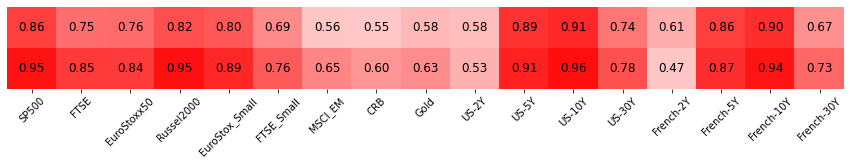

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(15,1.5), sharex=True)
r2 = pd.DataFrame(ae_test_eval['model']['r2'].values(), index = ae_test_eval['model']['r2'].keys()).T
sns.heatmap(r2,
            vmin=np.min(r2.values), 
            center=np.min(r2.values) - np.std(r2.values),
            vmax=1, 
            annot=True,
            yticklabels=False,
            fmt='.2f',
            annot_kws={'color': 'black', 'size': 'large', 'ha': 'center'},
            cmap='bwr',
            cbar=False,
            ax=axs[0]) # cmap='Reds')

r2 = pd.DataFrame(nmf_test_eval['model']['r2'].values(), index = nmf_test_eval['model']['r2'].keys()).T
sns.heatmap(r2,
            vmin=np.min(r2.values), 
            center=np.min(r2.values) - np.std(r2.values),
            vmax=1, 
            annot=True,
            yticklabels=False,
            fmt='.2f',
            cmap='bwr',
            annot_kws={'color': 'black', 'size': 'large', 'ha': 'center'},
            cbar=False,
            ax=axs[1]) # cmap='Reds')
plt.subplots_adjust(hspace = .0)
axs[1].tick_params(axis='x', labelrotation = 45,  labelsize=10)
if SAVE:
    plt.savefig(f'{savedir}/r2_heatmap_{DATASET}.png', bbox_inches='tight', transparent=True)

## Interpretation

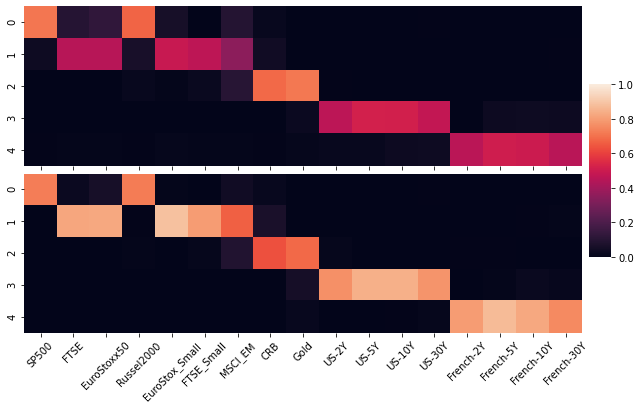

In [7]:
ae_loadings = np.array([decoding["ae"][k].values for k in decoding["ae"].keys()])
ae_avg_loadings = pd.DataFrame(ae_loadings.mean(0), index=assets)

w = decoding["nmf"][0].copy()
w = w /np.sqrt(np.sum(w**2))
(w**2).sum()


nmf_loadings = np.array([decoding["nmf"][k].values for k in decoding["nmf"].keys()])
nmf_avg_loadings = pd.DataFrame(nmf_loadings.mean(0), index=assets)


if DATASET == "dataset1":
    figsize=(10,4)
elif DATASET == "dataset2":
    figsize=(10,6)
fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(ae_avg_loadings.T, vmin=0, vmax=1, ax=axs[0], cbar=False)
sns.heatmap(nmf_avg_loadings.T, vmin=0, vmax=1, ax=axs[1], cbar=True, cbar_ax=cbar_ax)
plt.subplots_adjust(hspace = 0.05)
axs[1].tick_params(axis='x', labelrotation = 45,  labelsize=10)
if SAVE:
    plt.savefig(f'{savedir}/loading_avg_heatmap_{DATASET}.png', bbox_inches='tight', transparent=True)

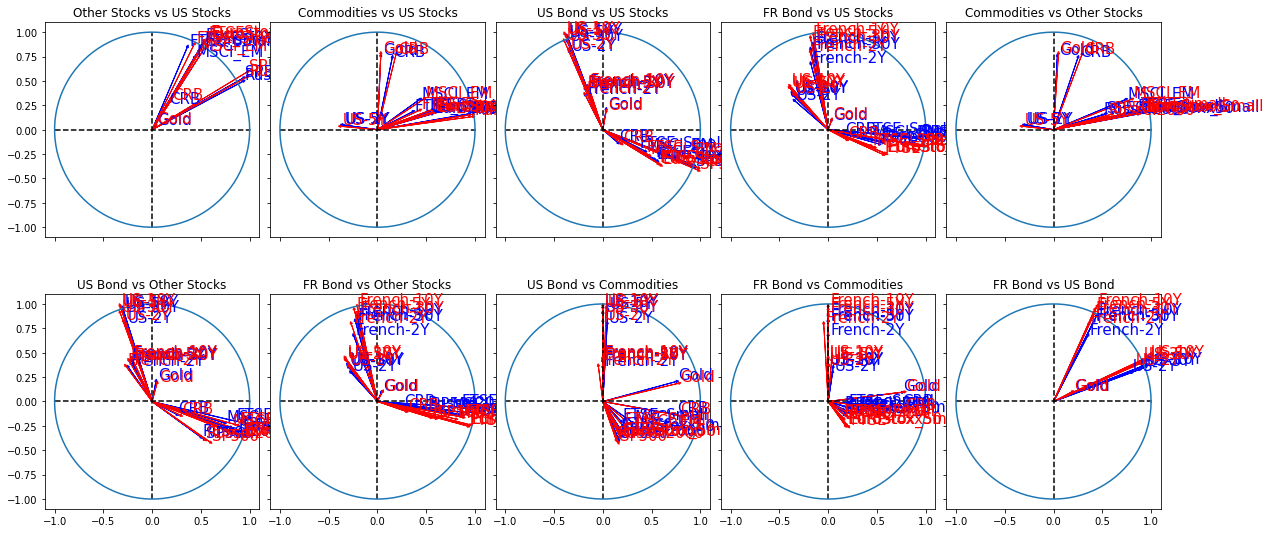

In [8]:
if SAVE:
    savepath = f'{savedir}/corr_asset_factor_{DATASET}.png'
else:
    savepath = None
    
intrepretation_plot(test_data, 
                    features, 
                    DATASET,
                    LABELS,
                    savepath=savepath,
                    corr="pearson")

## Factors distribution

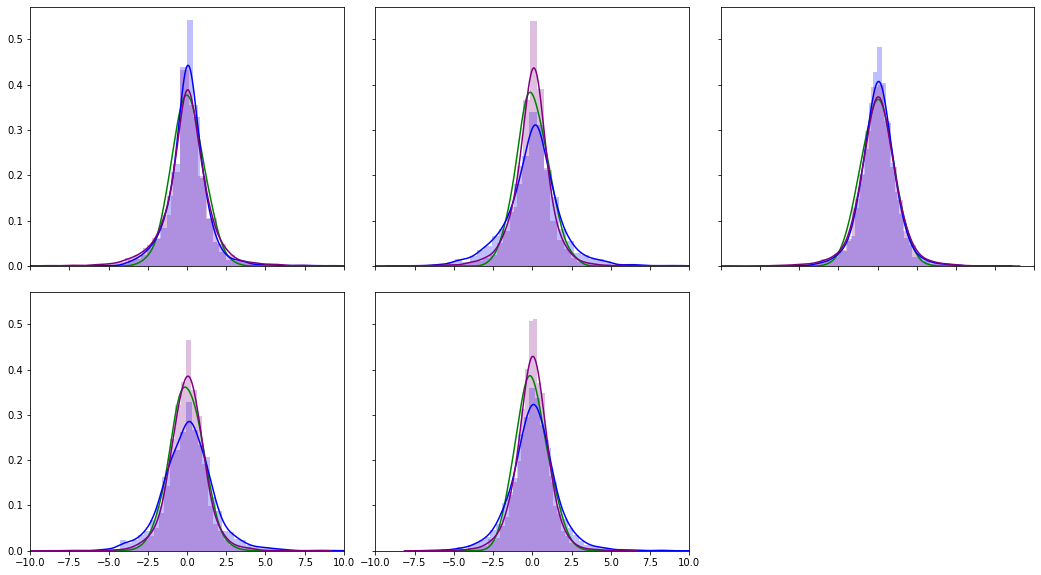

In [9]:
if SAVE:
    savepath=f'{savedir}/factor_distribution_{DATASET}.png'
else:
    savepath = None
    
start = features["ae"].index[0]
end = features["ae"].index[-1]
plt_features(features, start, end, DATASET, savepath=savepath)
